In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils
# %aimport ocfeats


In [11]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import ConvexHull

from tqdm.auto import tqdm, trange

from utilsLoaders import read_trc, read_mot
import feats_curls as ocfeats

datadir = Path('./datadir')

def get_trc_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'
    

In [5]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [9]:
df_session = pd.read_excel(datadir / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / 'participant_info.xlsx')


/Users/psr/opt/anaconda3/envs/opensim/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


mdf_017


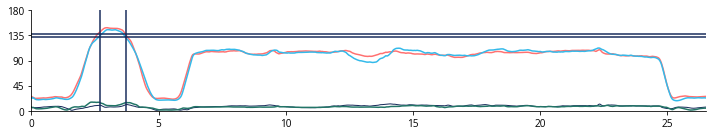

In [12]:
pid = 'p014'
# pid = 'p060'
# pid = 'p093'

df_temp = df_trial[df_trial.trial_clean == 'curls']
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]
print(pid)

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

rw = xyz[:,np.argmax(markers=='RWrist'),1]
lw = xyz[:,np.argmax(markers=='LWrist'),1]
mean_w = (rw + lw) / 2

rsa, rea, lsa, lea = ocfeats.trc_arm_angles(xyz, markers)

mean_sa = (rsa + lsa) / 2
mean_ea = (rea + lea) / 2

max_rsa = np.max(rsa)
max_lsa = np.max(lsa)

max_mean_sa = np.max(mean_sa)

rea_at_max_rsa = rea[np.argmax(rsa)]
lea_at_max_lsa = lea[np.argmax(lsa)]
mean_ea_at_max_mean_sa = mean_ea[np.argmax(mean_sa)]

rea_at_max_rw = rea[np.argmax(rw)]
lea_at_max_lw = lea[np.argmax(lw)]
mean_ea_at_max_mean_w = mean_ea[np.argmax(mean_w)]

t = np.arange(xyz.shape[0]) / fps
plt.figure(figsize=(10,2))
plt.plot(t, rsa, lw=1)
plt.plot(t, rea)
plt.plot(t, lsa)
plt.plot(t, lea)
plt.axhline(mean_ea_at_max_mean_sa)
plt.axhline(mean_ea_at_max_mean_w)
plt.axvline(t[np.argmax(mean_sa)])
plt.axvline(t[np.argmax(mean_w)])
plt.xlim(t[0], t[-1])
plt.ylim(0, 180)
plt.yticks([0, 45, 90, 135, 180])
plt.tight_layout()
plt.show()


  0%|          | 0/156 [00:00<?, ?it/s]

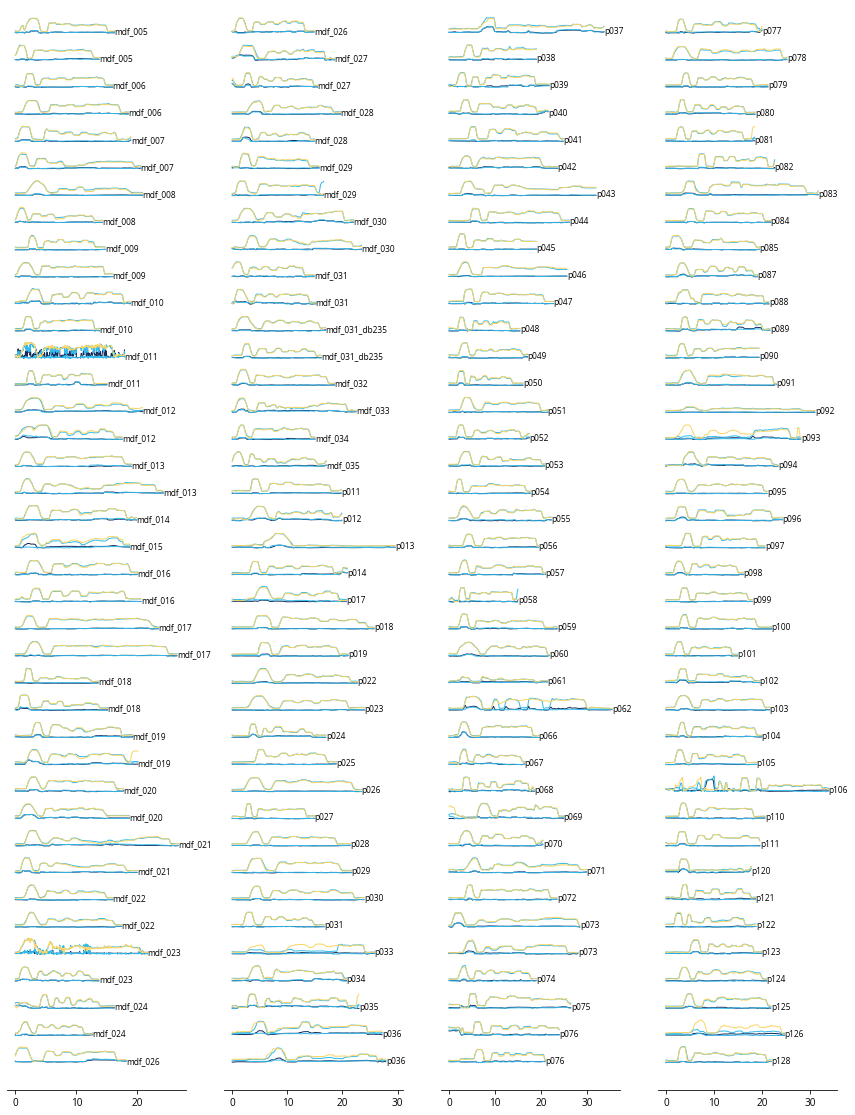

In [35]:
df = df_trial[df_trial.trial_clean=='curls']
# df_sts = df_sts.iloc[:50]
n = len(df)

ncols = 4

plt.figure(figsize=(3*ncols,n/10))

for i in trange(n):
    row = df.iloc[i]
    pid = row.pid

    # if pid not in ('mdf_015', 'mdf_006', 'mdf_018', 'mdf_023', 'p023', 'p037', 'p045', 'p069', 'p074', 'p095', 'p122'):
    #     continue
    
    sid, trial = row.sid, row.trial
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
    
    rsa, rea, lsa, lea = ocfeats.trc_arm_angles(xyz, markers)
    
    # nordy = lambda x: (x - x.min()) / x.ptp()
    nordy = lambda x: x / 180
    rsa = nordy(rsa)
    rea = nordy(rea)
    lsa = nordy(lsa)
    lea = nordy(lea)

    t = np.arange(rsa.size) / fps

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, rsa-i%(n/ncols)*1.5, lw=1, c=cp[0])
    plt.plot(t, lsa-i%(n/ncols)*1.5, lw=1, c=cp[3])
    plt.plot(t, rea-i%(n/ncols)*1.5, lw=1, c=cp[3])
    plt.plot(t, lea-i%(n/ncols)*1.5, lw=1, c=cp[4])
    # plt.scatter(t[locs], h[locs]-i%(n/ncols)*1.5, s=6, c=cp[0])
    # plt.scatter(t[la], h[la]-i%(n/ncols)*1.5, s=6, c=cp[3])
    # plt.scatter(t[lb], h[lb]-i%(n/ncols)*1.5, s=6, c=cp[3])
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)

    # if i > 10:
    #     break
    
sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_curls.pdf')
plt.show()


In [13]:
df_temp = df_trial[df_trial.trial_clean == 'curls']
data = []
for i, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
    pid, sid, trial = row[['pid', 'sid', 'trial']]
    # print(pid)

    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    rsa, rea, lsa, lea = ocfeats.trc_arm_angles(xyz, markers)
    max_rea = np.max(rea)
    max_lea = np.max(lea)
    mean_ea = (rea + lea) / 2
    max_mean_ea = np.max(mean_ea)
    
    data.append({'pid': pid,
                 'max_rea': max_rea,
                 'max_lea': max_lea,
                 'max_mean_ea': max_mean_ea,
                })


  0%|          | 0/156 [00:00<?, ?it/s]

/Users/psr/opt/anaconda3/envs/opensim/lib/python3.9/site-packages/seaborn/categorical.py:3540: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/psr/opt/anaconda3/envs/opensim/lib/python3.9/site-packages/seaborn/categorical.py:3540: UserWarning: 19.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


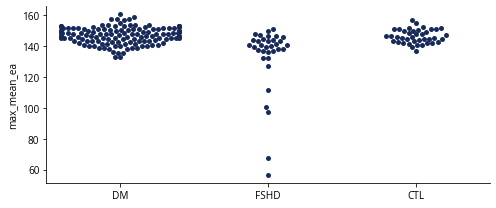

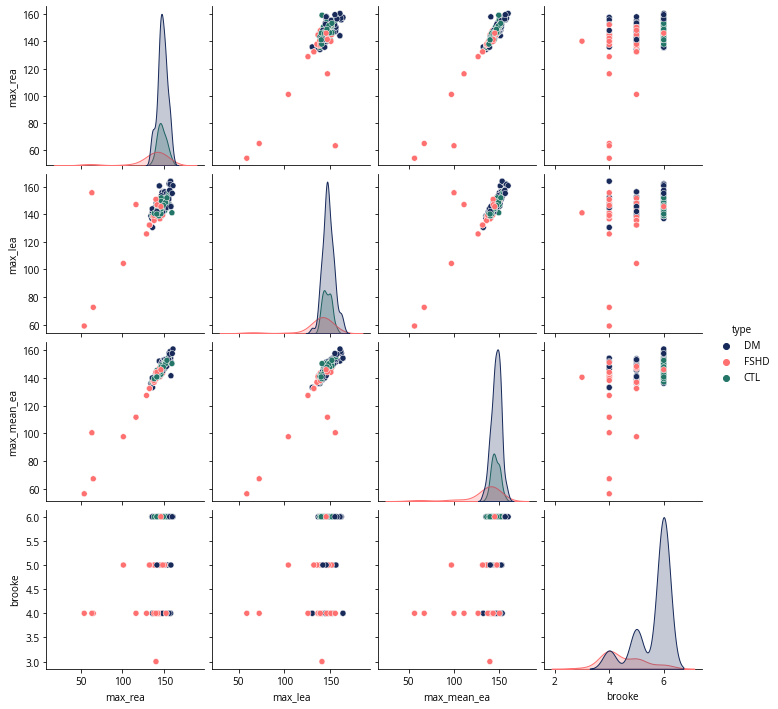

In [14]:
df_brooke = pd.DataFrame(data)
df_temp = df_brooke.merge(df_part[['pid', 'brooke', 'type']],
                          on='pid', how='left')

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='max_mean_ea')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

sns.pairplot(df_temp, hue='type')
plt.show()
